# 0.0. IMPORTS

In [1]:
import math
import json
import random
import requests
import pickle
import numpy                as np
import pandas               as pd
import xgboost              as xgb
import seaborn              as sns
import datetime
import inflection
import matplotlib.gridspec  as gridspec

from scipy                  import stats
from flask                  import Flask, request ,Response
from boruta                 import BorutaPy
from matplotlib             import pyplot as plt
from IPython.display        import Image
from IPython.core.display   import HTML

from sklearn.metrics        import mean_absolute_error, mean_squared_error # mean_absolute_percentage_error
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import LinearRegression, Lasso
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder

#from api.rossmann           import Rossmann

In [2]:
import os
os.chdir('../')

In [3]:
# Supressão da notação científica.
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.4f}'.format)

## 0.1. Helper Functions

In [4]:
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( (y- yhat) / y) )

def ml_error(model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( {  'Model Name': model_name,
                            'MAE': mae,
                            'MAPE': mape,
                            'RMSE': rmse}, index=[0] )

In [5]:
def cross_validation (model_name, X_training, kfold, model, verbose = False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    #Só por aprendizado
    #iteracao = []
    #treino_inicio = []
    #treino_fim = []
    #validação_inicio = []
    #validação_fim = []
    
    
    # Star an end date validation
    for k in reversed( range (1, kfold+1) ):
        if verbose:
            print('\nKfold: {}'.format(k))
        validation_start_date = X_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date = X_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)

        # Filter Data Set
        treino = X_training[X_training['date'] < validation_start_date]
        validacao = X_training[(X_training['date'] >= validation_start_date) & (X_training['date'] <= validation_end_date)]

        # Training and validation dataset
        # Treino
        xtreino = treino.drop( ['date','sales'] , axis = 1)
        ytreino = treino['sales']

        # Validação
        xvalidacao = validacao.drop( ['date','sales'] , axis = 1)
        yvalidacao = validacao['sales']

        # Modelo
        m = model.fit( xtreino, ytreino )

        # Predição
        yhat_m = m.predict( xvalidacao )

        # Performance
        m_result = ml_error( 'Linear Regression', np.expm1( yvalidacao ), np.expm1( yhat_m ) )
        
        # Guardando as performaces
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
        
        #iteracao.append(k)
        #treino_inicio.append(treino['date'].min())
        #treino_fim.append(treino['date'].max())
        #validação_inicio.append(validacao['date'].min())
        #validação_fim.append(validacao['date'].max())
        
    resposta_modelo = pd.DataFrame( {  'Model Name': model_name,
                            'MAE CV' : np.round( np.mean( mae_list ), 2 ).astype('str') + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype('str'),
                            'MAPE CV' : np.round( np.mean( mape_list ), 2 ).astype('str') + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype('str'),
                            'RMSE CV' : np.round( np.mean( rmse_list ), 2 ).astype('str') + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype('str')},
                            index = [0])
    
    # Fazendo somente por questões de aprendizagem
    #curiosidade = pd.DataFrame({'Iteracao' : iteracao,
    #                            'Treino Início' : treino_inicio,
    #                            'Treino Fim' : treino_fim,
    #                            'Validação Início' : validação_inicio,
    #                            'Validação Fim' : validação_fim} )
    return resposta_modelo #, curiosidade

In [6]:
def cramer_v(x, y):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( ( chi2corr/n ) / ( min( kcorr-1,rcorr-1 ) ) )

In [7]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18,10]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width: 100% !important;} </style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False)
    
    sns.set()

In [8]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


d:\Git_Hub\venv310\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2. Loading Data

In [9]:
df_sales_raw = pd.read_csv('data_set/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data_set/store.csv', low_memory=False)

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

In [10]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
130542,88,7,2015-04-05,0,0,0,0,0,0,a,a,10690.0000,10.0000,2005.0000,0,NaN,NaN,NaN


# 1.0. DESCRIÇÃO DE DADOS

In [10]:
df1 = df_raw.copy()

## 1.1. Rename Columns
Curto, Intuitívo, Fácil Acesso. Melhora para o nosso trabalho

In [11]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x : inflection.underscore( x )

cols_new = list( map( snakecase, cols_old) )

#rename

df1.columns = cols_new

## 1.2. Data Dimensions

In [13]:
df1.shape

(1017209, 18)

## 1.3. Data Types

In [14]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
df1['date'] = pd.to_datetime( df1['date'] )

## 1.4. Check NA

In [16]:
# Forma de tratamentos de NA
# 1. Jogar as linhas fora - Rápido e fácil, mas joga dados fora
# 2. Algoritimos de ML, subtituir pelo comportamento da coluna, mediana, média.
# 3. Entendendo o negócio, ai é sobre como compreender o negócio.
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [13]:
# competition_distance - Como ela é a distancia da concorrencia mais próxima, então, podemos assumir a premissa que
# se está NA o competidor mais próximo não existe ou não é considerado um competidor.
df1['competition_distance'] = df1['competition_distance'].apply(lambda x : 2000000.0 if math.isnan( x ) else x)

# competition_open_since_month - Talvez não tenha uma competição mais próxima ou ela abriu muito antes de chegarmos ao local
# ou quando ela abriu ninguem anotou o dado.
# Com o metodo CRISP, iremos assumir a data de venda como a data que o competidor abriu.
# Caso precise trabalhar na acurácia a gente volta para esse ponto
df1['competition_open_since_month'] = df1.apply(lambda x : x['date'].month
                                                if math.isnan( x['competition_open_since_month'] )
                                                else x['competition_open_since_month'],
                                                axis = 1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x : x['date'].year
                                                if math.isnan( x['competition_open_since_year'] )
                                                else x['competition_open_since_year'],
                                                axis = 1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x : x['date'].week
                                                if math.isnan( x['promo2_since_week'] )
                                                else x['promo2_since_week'],
                                                axis = 1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x : x['date'].year
                                                if math.isnan( x['promo2_since_year'] )
                                                else x['promo2_since_year'],
                                                axis = 1)

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True ) # preenchimento do NA com 0 para facilitar a compraração

df1['month_map'] = df1['date'].dt.month.map( month_map ) # Extração do mês da 'data' 
# dt -> to date / month -> para mês / mapear e substituir

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else
                                                             1 if x['month_map'] in x['promo_interval'].split(',') else 0,
                                                             axis = 1)

In [18]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change types

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

## 1.7. Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes( include = ['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Atributes

In [21]:
# Medidas de Tendencia Central - Media e Mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Medidas de Disperção - (Desvio Padrão)std, min, max, (Tamanho)range, (Amplitude)skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concat
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['atributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,atributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0000,1115.0000,1114.0000,558.4297,558.0000,321.9085,-0.0010,-1.2005
1,day_of_week,1.0000,7.0000,6.0000,3.9983,4.0000,1.9974,0.0016,-1.2469
2,sales,0.0000,41551.0000,41551.0000,5773.8190,5744.0000,3849.9243,0.6415,1.7784
3,customers,0.0000,7388.0000,7388.0000,633.1459,609.0000,464.4115,1.5987,7.0918
4,open,0.0000,1.0000,1.0000,0.8301,1.0000,0.3755,-1.7580,1.0907
5,promo,0.0000,1.0000,1.0000,0.3815,0.0000,0.4858,0.4878,-1.7620
6,school_holiday,0.0000,1.0000,1.0000,0.1786,0.0000,0.3831,1.6778,0.8152
7,competition_distance,20.0000,2000000.0000,1999980.0000,10610.5881,2330.0000,101810.6491,19.3780,375.6444
8,competition_open_since_month,1.0000,12.0000,11.0000,6.7868,7.0000,3.3111,-0.0421,-1.2326
9,competition_open_since_year,1900.0000,2015.0000,115.0000,2010.3248,2012.0000,5.5156,-7.2357,124.0713


### 1.7.2 Categorial Atributes

<AxesSubplot:xlabel='assortment', ylabel='sales'>

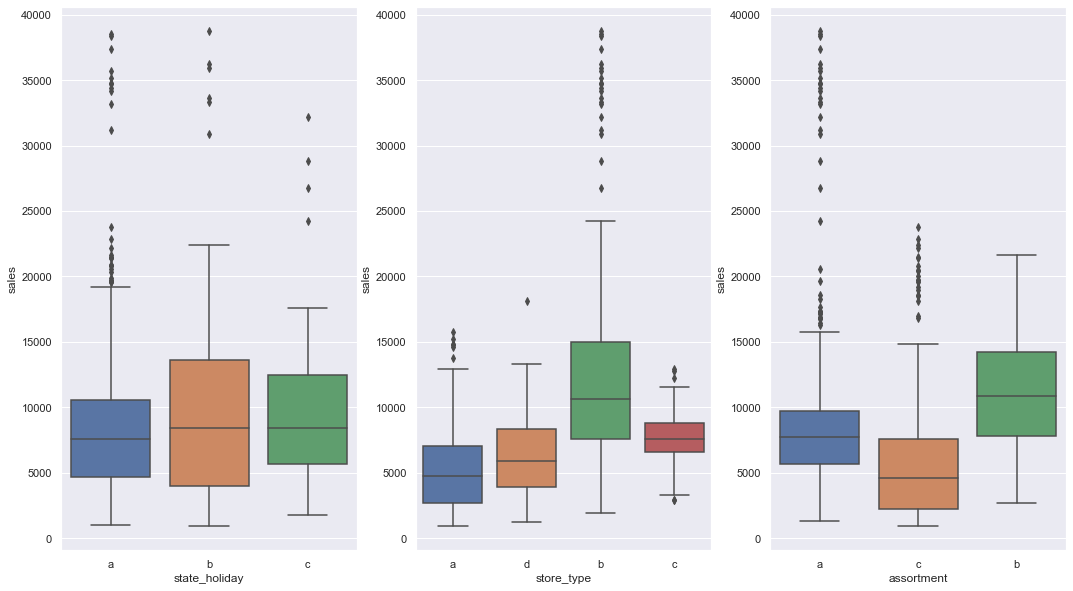

In [22]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot( data=aux1 , x='state_holiday' , y='sales')

plt.subplot(1, 3, 2)
sns.boxplot( data=aux1 , x='store_type' , y='sales')

plt.subplot(1, 3, 3)
sns.boxplot( data=aux1 , x='assortment' , y='sales')

# 2.0 FEATURE ENGENEERIN

In [16]:
df2 = df1.copy()

## 2.1. Mapa mental das hipóteses

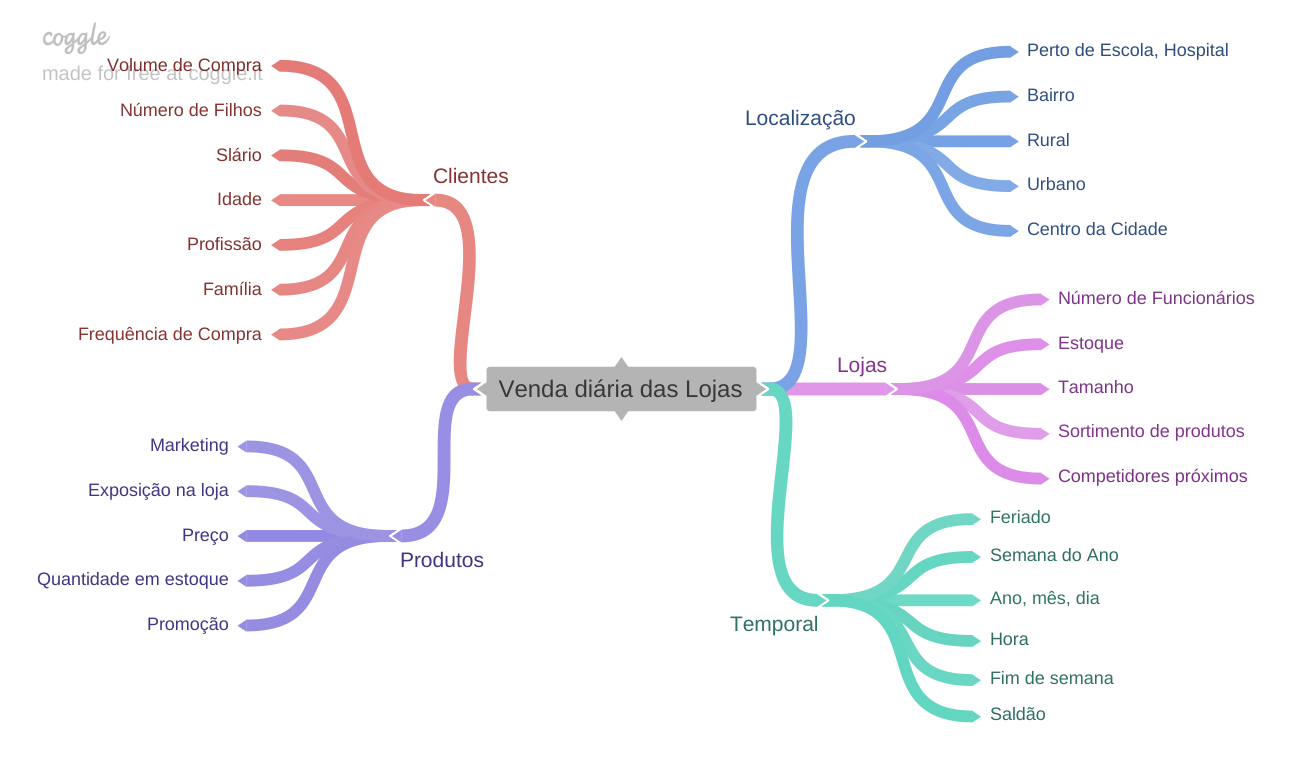

In [24]:
Image('image\Venda_diria_das_Lojas.png')

## 2.2. Criação das Hipóteses

### 2.2.1. Hipóteses Loja

**1.** Lojas com maior número de funcionario deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo vender mais.

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preços menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas (maiores descontos), deveriam vender mais.

**5.** Lojas com promoção ativa por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecultivas deveriam vender mais.

### 2.2.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Lista final de Hipóteses

__Loja__

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo vender mais.

__Produto__

**4.** Lojas com promoção ativa por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecultivas deveriam vender mais.


__Tempo__

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

In [17]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since - quanto tempo da data da compra desde quando a competição começou
# datetime.datetime() - junta datasa distintas em uma data só.
# O que estamos fazendo aqui:
# 1. Estamos juntando as duas colunas de mês e ano para poder fazer a conta.
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
# 2. A conta. Estamos subtraindo o mês do início da competição, do mês da compra. Assim obtendo os meses desde então.
# 3. A função x.days extrai somente os dias do resultado da conta que foi feita.
# 4. Se não lembrar como funciona retira tudo do apply para frente e roda o código. ".apply(lambda x: x.days).astype('int64')"
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype('int64')

# promo since
# Transformando em uma string pq temos a semana e não o mês, depois transforma isso em date novamente
df2['promo_since'] = df2['promo2_since_year'].astype('str') + '-' + df2['promo2_since_week'].astype('str')
# Aqui a gente transforma a str em date - não sei como, mas transforma, vamo boiando, depois aprende
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x +'-1', '%Y-%W-%w') - datetime.timedelta(days=7) )
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) /7).apply( lambda x: x.days).astype('int64')

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a'
                                            else'extra' if x == 'b'
                                            else 'extended')

# state hollyday
df2['state_holiday'] = df2['state_holiday'].apply(  lambda x: 'public_holiday' if x == 'a'
                                                    else 'easter_holiday' if x == 'b'
                                                    else 'christmas' if x == 'c'
                                                    else 'regular_day')

# 3.0 FILTRAGEM DAS VARIÁVEIS

In [18]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [19]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das Colunas

In [20]:
# open: depois de filtrada só restará o valor 1, sendo assim, não agregando em nada na nossa base de dados.
# promo_interval, month_map: foi construida para mostrar se aquela loja tem ou não promoção
#                            não agregando nada depois que a coluna is_promo está pronta.

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 Análise Exploratória de Dados - EDA

In [21]:
df4 = df3.copy()

## 4.1. Análise univariada

### 4.1.1 Variável Resposta

count   844338.0000
mean      6955.9591
std       3103.8155
min         46.0000
25%       4859.0000
50%       6369.0000
75%       8360.0000
max      41551.0000
Name: sales, dtype: float64
count   844338.0000
mean         8.7577
std          0.4252
min          3.8501
25%          8.4888
50%          8.7594
75%          9.0313
max         10.6347
Name: sales, dtype: float64


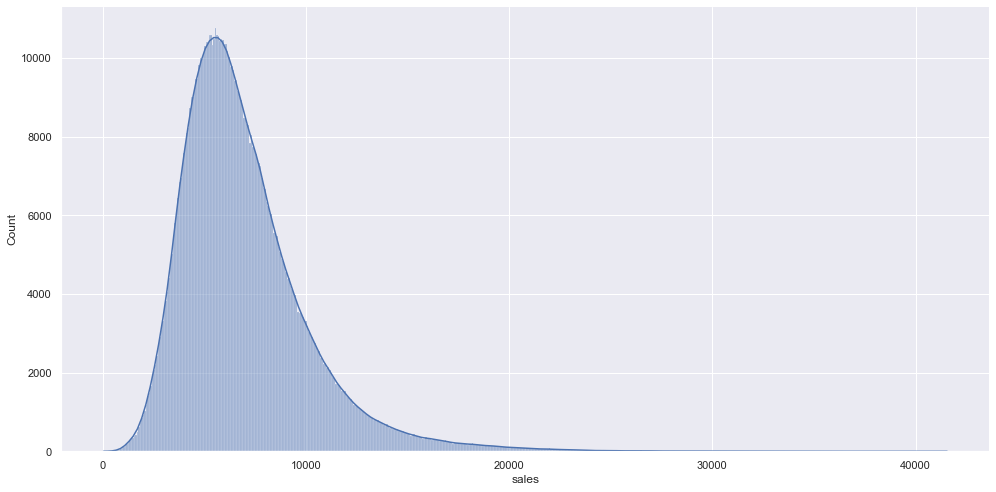

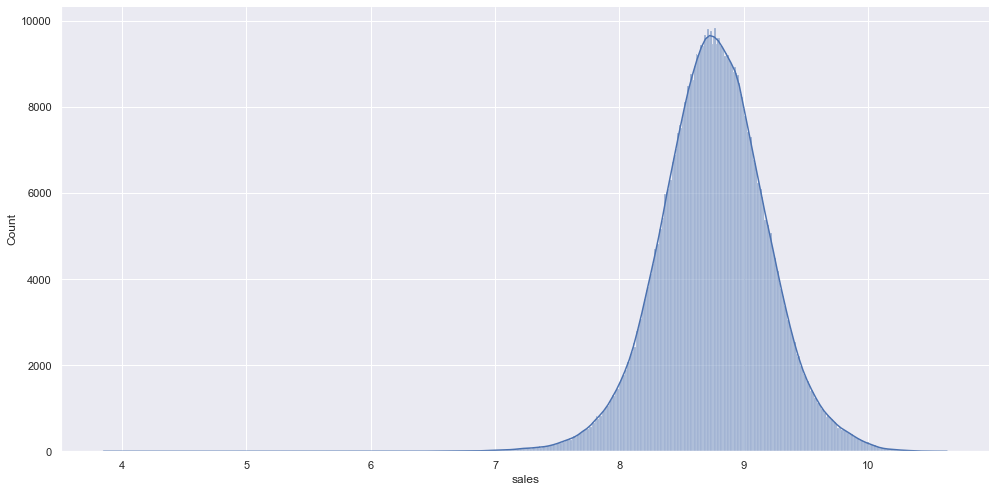

In [53]:
sns.displot(df4['sales'], kde=True, height=7, aspect=2)
#
#print(df4['sales'].describe())
#aux_log = np.log1p( df4['sales'])
#print(aux_log.describe())
#
#sns.displot(aux_log, kde=True, height=7, aspect=2)

### 4.1.2 Vairáveis Numéricas

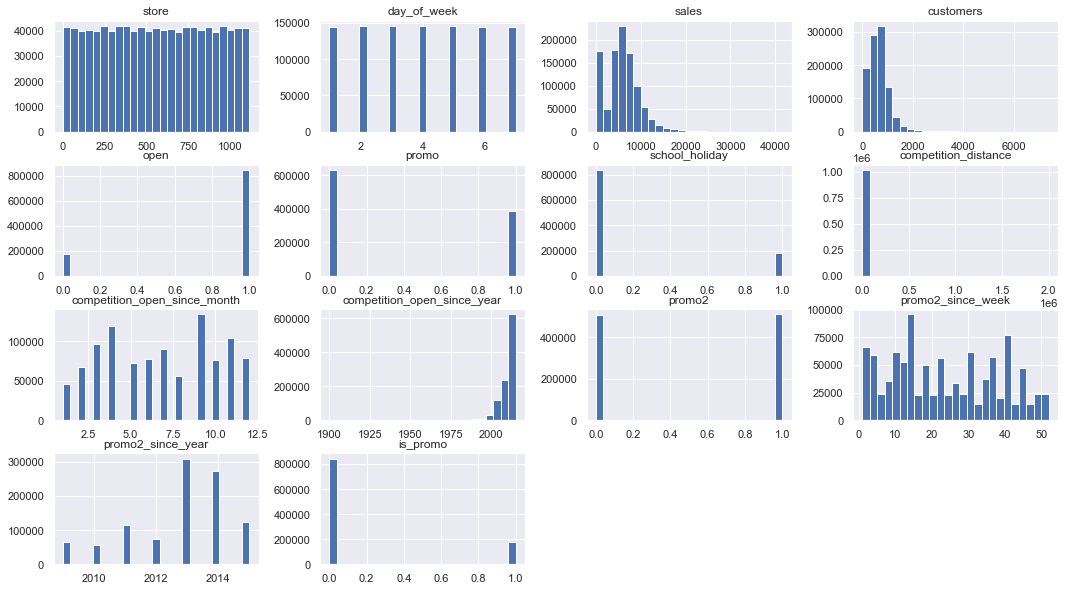

In [31]:
num_attributes.hist(bins = 25);

### 4.1.3 Vairáveis Categóricas

d:\Git_Hub\venv310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\Git_Hub\venv310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\Git_Hub\venv310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

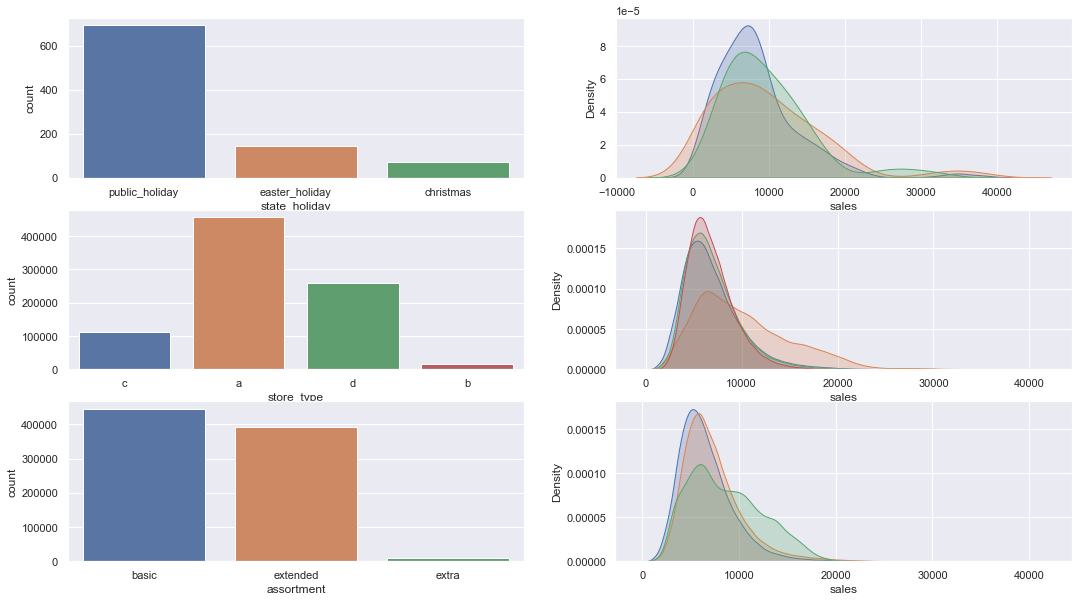

In [32]:
# state_holiday
plt.subplot( 3,2,1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3,2,2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade=True )

# store_type
plt.subplot( 3,2,3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3,2,4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label = 'a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label = 'b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label = 'c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label = 'd', shade=True )

# assortment
plt.subplot( 3,2,5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3,2,6 )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade=True )

## 4.2. Análise bivariada

### Resumo das Hipóteses

| Hipótese | Resultato | Relevancia |
| -------- | --------- | ---------- |
| H1 | FALSA | BAIXA |
| H2 | FALSA | MEDIA |
| H3 | FALSA | MEDIA |
| H4 | FALSA | BAIXA |
| H5 | --- | ---  |
| H6 | FALSA | BAIXA |
| H7 | FALSA | MEDIA |
| H8 | FALSA | ALTA |
| H9 | FALSA | ALTA |
| H10 | VERDADEIRA | ALTA |
| H11 | VERDADEIRA | ALTA |
| H12 | VERDADEIRA | BAIXA |

### **H1.** Lojas com maior sortimento deveriam vender mais.

**FALSA.** Lojas com MAIOR SORTIMENTO vendem MENOS.

<AxesSubplot:xlabel='year_week'>

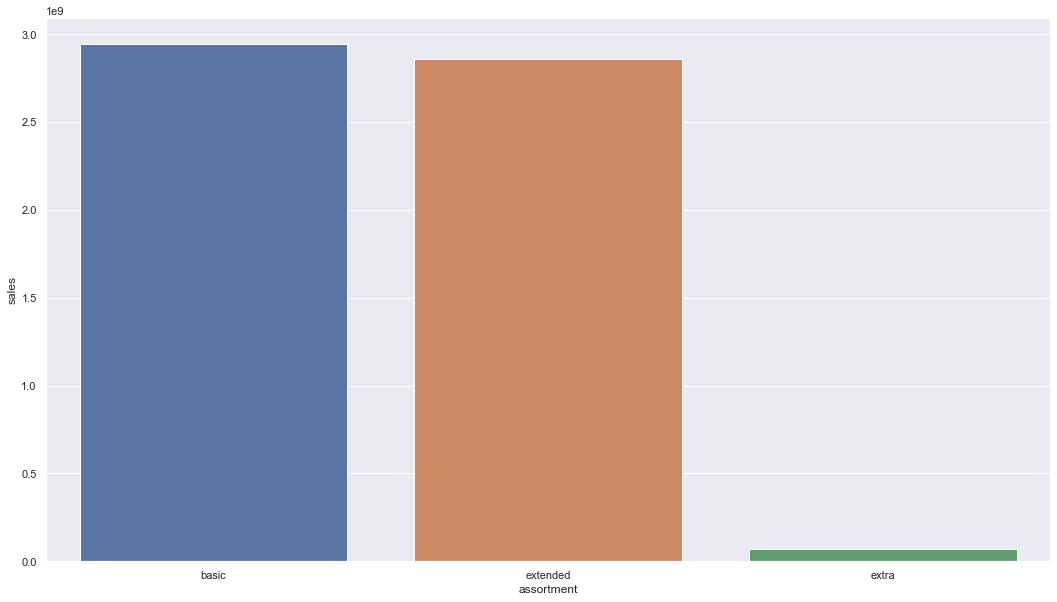

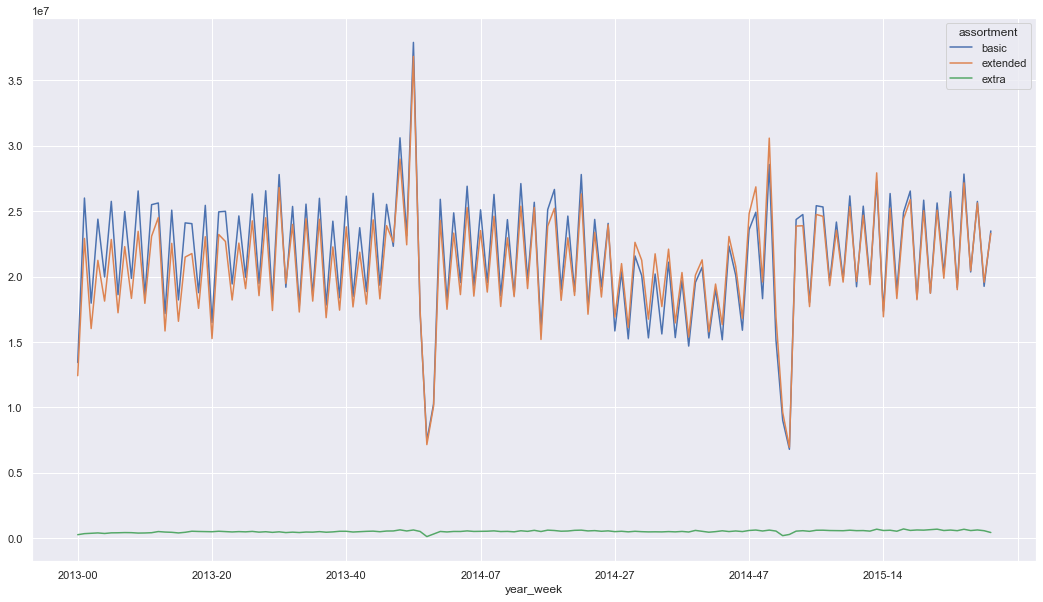

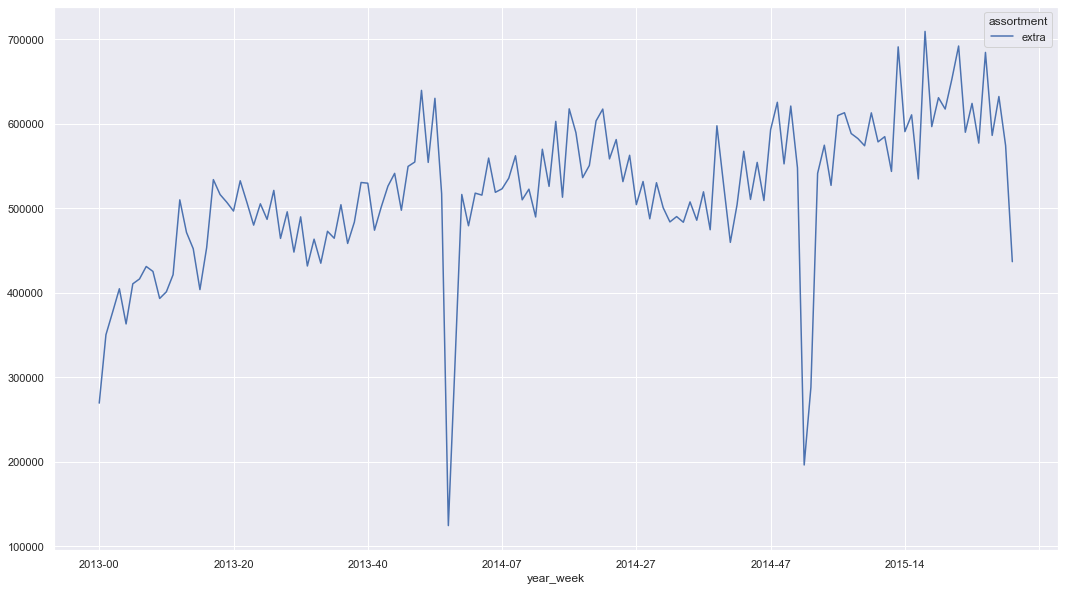

In [33]:
h1_aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=h1_aux1);

h1_aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
h1_aux2.pivot( index='year_week' , columns='assortment', values='sales').plot()

h1_aux3 = h1_aux2[h1_aux2['assortment'] == 'extra']
h1_aux3.pivot( index='year_week' , columns='assortment', values='sales').plot()

### **H2.** Lojas com competidores mais próximos deveriam vender menos.

Esse exemplo é o insight surpreendente, pois não se espera muitas vendas em pontos de competição próximo. Ou seja.

**Falsa.** Loja com competidores mais próximos vendem mais.

<AxesSubplot:>

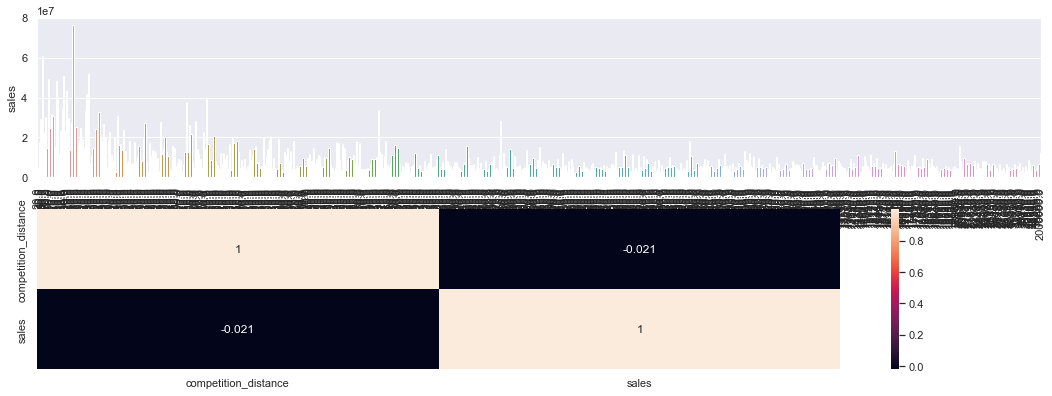

In [34]:
plt.subplot(3,1,1)
h2_aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
sns.barplot( x='competition_distance', y='sales', data = h2_aux1);
plt.xticks( rotation=90)

bins = list( np.arange( 0, 20000, 1000) )
h2_aux1['competition_distance_binned'] = pd.cut( h2_aux1['competition_distance'], bins=bins)

plt.subplot(3,1,2)
h2_aux2 = h2_aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data = h2_aux2);

#Com dados muito concentrado pode ser feito um scatereplot

h2_aux3 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot( x='competition_distance', y='sales', data = h2_aux3);

#Força da correlação entre a competition distance e as vendas
# A correlação vai de 1 a -1.
# Quanto mais próximo de 1 e -1 a correlação é forte, quanto mais próxima de 0 a correlação é inexistente.
# 1: Forte proporcional.
# -1: Forte inversamente proporcional. 
sns.heatmap( h2_aux1.corr( method='pearson'), annot=True)

### **H3.** Lojas com competidores a mais tempo vender mais.

**FALSA.** Loja com competição a menos tempo vende mais.

<AxesSubplot:>

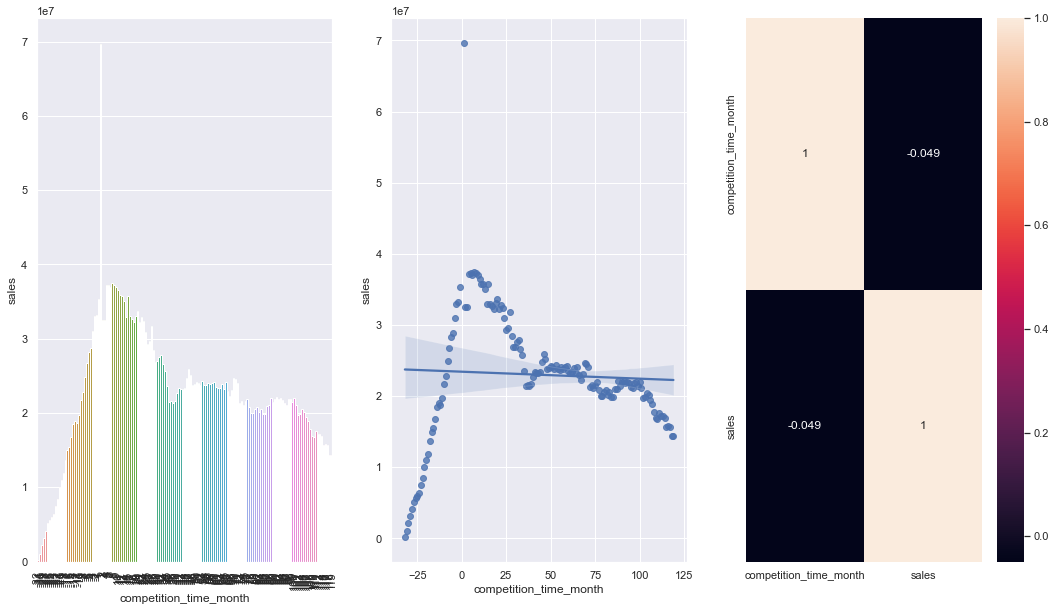

In [35]:
h3_aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
h3_aux2 = h3_aux1[(h3_aux1['competition_time_month'] < 120) & (h3_aux1['competition_time_month'] != 0)]

plt.subplot(1,3,1)
sns.barplot( x='competition_time_month', y='sales', data = h3_aux2);
plt.xticks( rotation=90 );

plt.subplot(1,3,2)
sns.regplot( x='competition_time_month', y='sales', data = h3_aux2);

plt.subplot(1,3,3)
sns.heatmap( h3_aux2.corr( method='pearson'), annot=True)

### **H4.** Lojas com promoção ativa por mais tempo deveriam vender mais.

**FALSA.** Lojas com promoção ativa por mais tempo vendem menos, depois de um certo período de promoção.

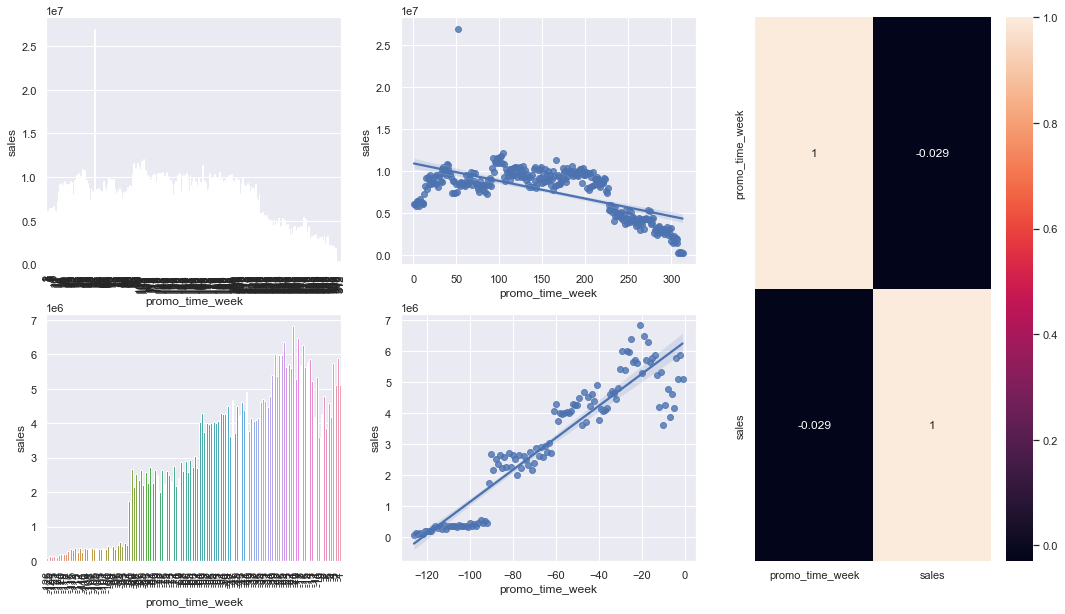

In [36]:
h4_aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

h4_aux2 = h4_aux1[h4_aux1['promo_time_week'] > 0] # promo extend
h4_aux3 = h4_aux1[h4_aux1['promo_time_week'] < 0] # promo regular

grid = gridspec.GridSpec(2,3)

plt.subplot(grid[0,0])
sns.barplot( x='promo_time_week', y='sales', data = h4_aux2);
plt.xticks( rotation=90);
plt.subplot(grid[0,1])
sns.regplot( x='promo_time_week', y='sales', data = h4_aux2);

plt.subplot(grid[1,0])
sns.barplot( x='promo_time_week', y='sales', data = h4_aux3);
plt.xticks( rotation=90);
plt.subplot(grid[1,1])
sns.regplot( x='promo_time_week', y='sales', data = h4_aux3);

plt.subplot(grid[:,2])
sns.heatmap( h4_aux1.corr(method = 'pearson' ), annot= True );

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **H6.** Lojas com mais promoções consecultivas deveriam vender mais.

**FALSA.** Lojas com promoções consecultivas vendem menos.

In [37]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index().sort_values('sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**FALSA.** Loja abertas no feriado de natal vendem menos.

<AxesSubplot:xlabel='year', ylabel='sales'>

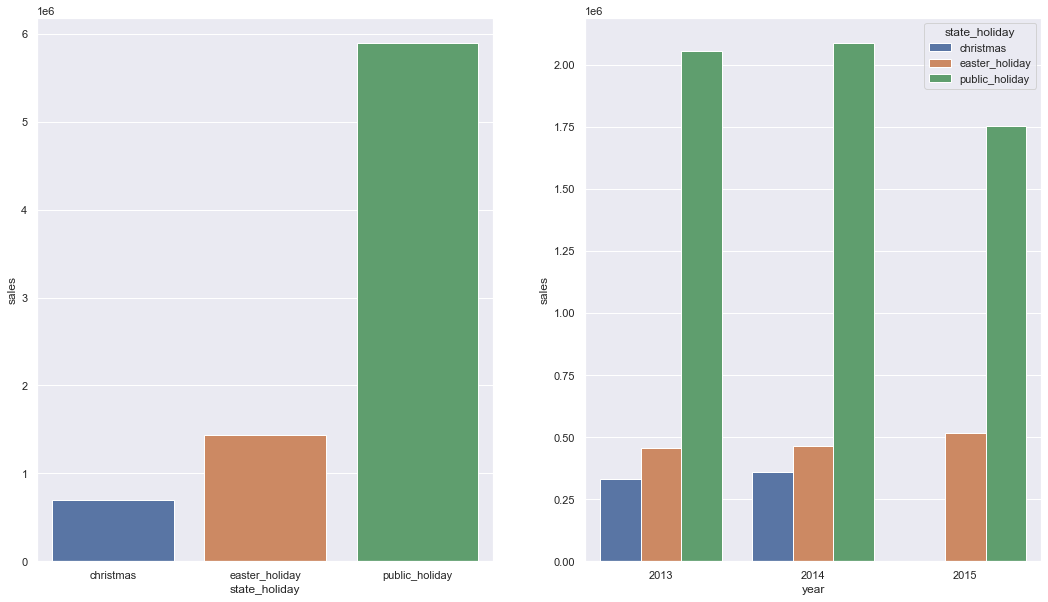

In [38]:
h7_aux1 = df4[df4['state_holiday'] !='regular_day']
h7_aux2 = h7_aux1[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot( x='state_holiday', y='sales', data=h7_aux2 )

plt.subplot(1,2,2)
h7_aux3 = h7_aux1[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=h7_aux3 )

### **H8.** Lojas deveriam vender mais ao longo dos anos.

**FALSA.** Lojas abertar com mais tempo vendem menos.

Atenção. Sempre pegue períodos fechados. 2015 ainda está em aberto.

<AxesSubplot:>

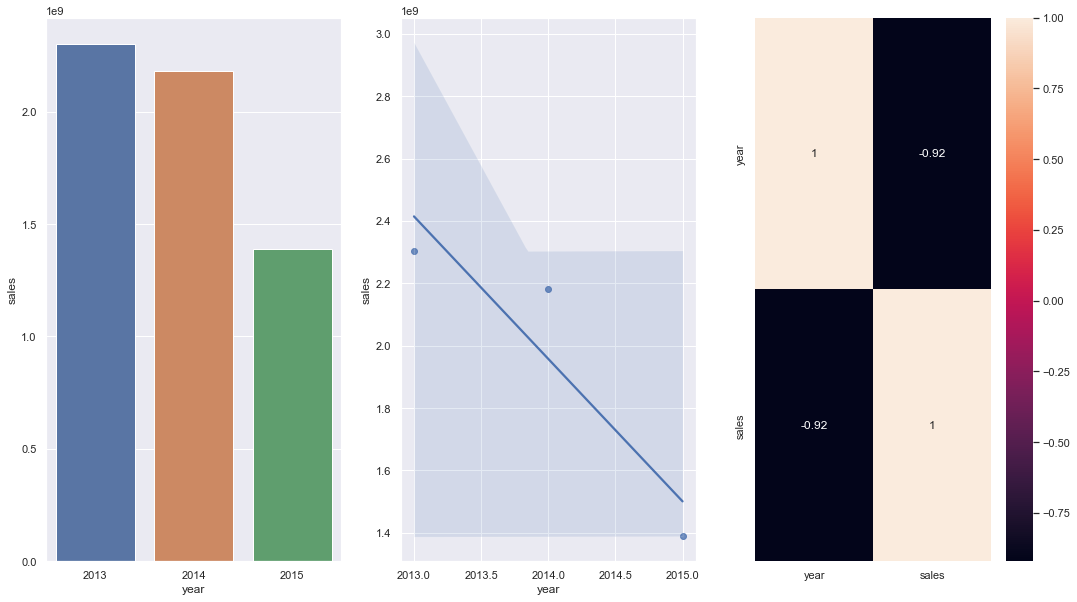

In [39]:
h8_aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot( x='year', y='sales', data=h8_aux1)

plt.subplot(1,3,2)
sns.regplot( x='year', y='sales', data=h8_aux1)

plt.subplot(1,3,3)
sns.heatmap(h8_aux1.corr(method='pearson'), annot=True)

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.

**FALSA.** As lojas vendem menos no segundo semestre.

<AxesSubplot:>

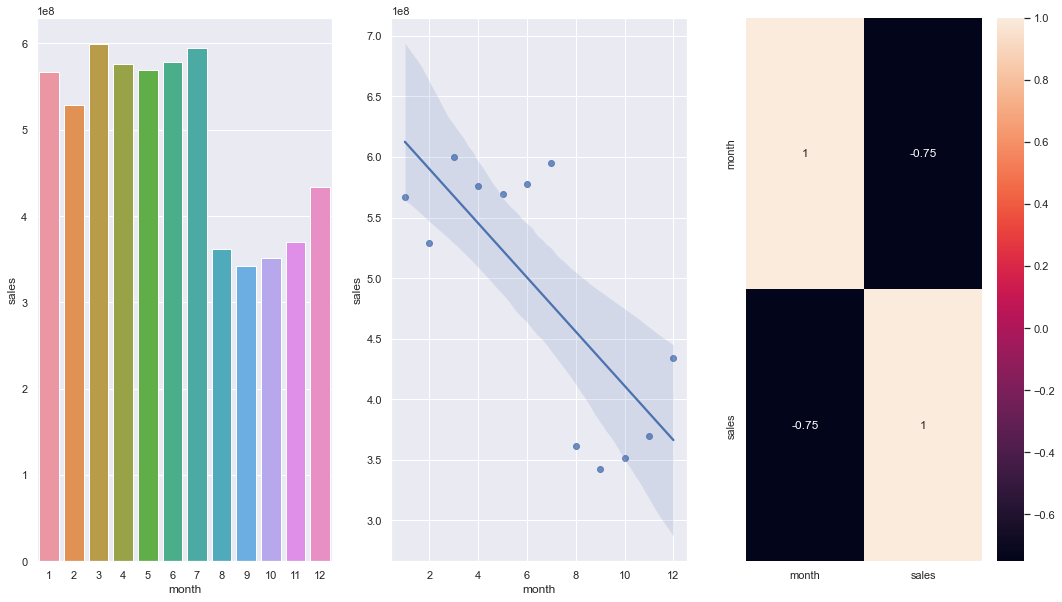

In [40]:
h9_aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot( x='month', y='sales', data=h9_aux1)

plt.subplot(1,3,2)
sns.regplot( x='month', y='sales', data=h9_aux1)

plt.subplot(1,3,3)
sns.heatmap(h9_aux1.corr(method='pearson'), annot=True)

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**VERDADEIRA.** Lojas vendem mais depois do dia 10

<AxesSubplot:xlabel='antes_depois', ylabel='sales'>

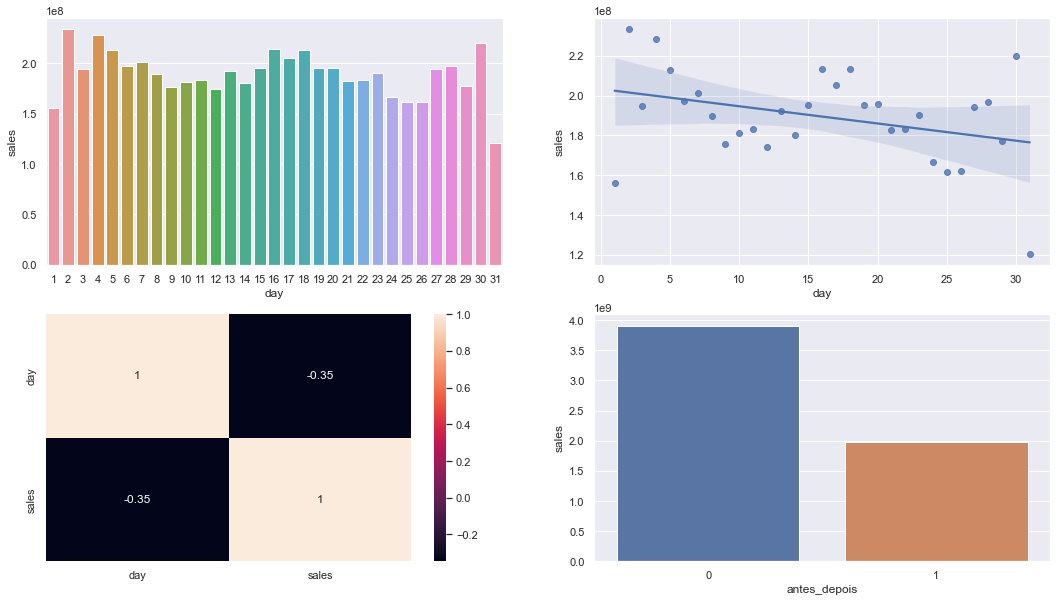

In [41]:
h10_aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot( x='day', y='sales', data=h10_aux1)

plt.subplot(2,2,2)
sns.regplot( x='day', y='sales', data=h10_aux1)

plt.subplot(2,2,3)
sns.heatmap(h10_aux1.corr(method='pearson'), annot=True)

# 1 = até dia 10
# 0 = do dia 11 até o final do mês
h10_aux1['antes_depois'] = h10_aux1['day'].apply(lambda x: 1 if x <= 10 else 0)
h10_aux2 = h10_aux1[['antes_depois','sales']].groupby('antes_depois').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot( x='antes_depois', y='sales', data=h10_aux2)

### **H11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRO.** Lojas vendem menos aos final de semana.

<AxesSubplot:xlabel='weekend', ylabel='sales'>

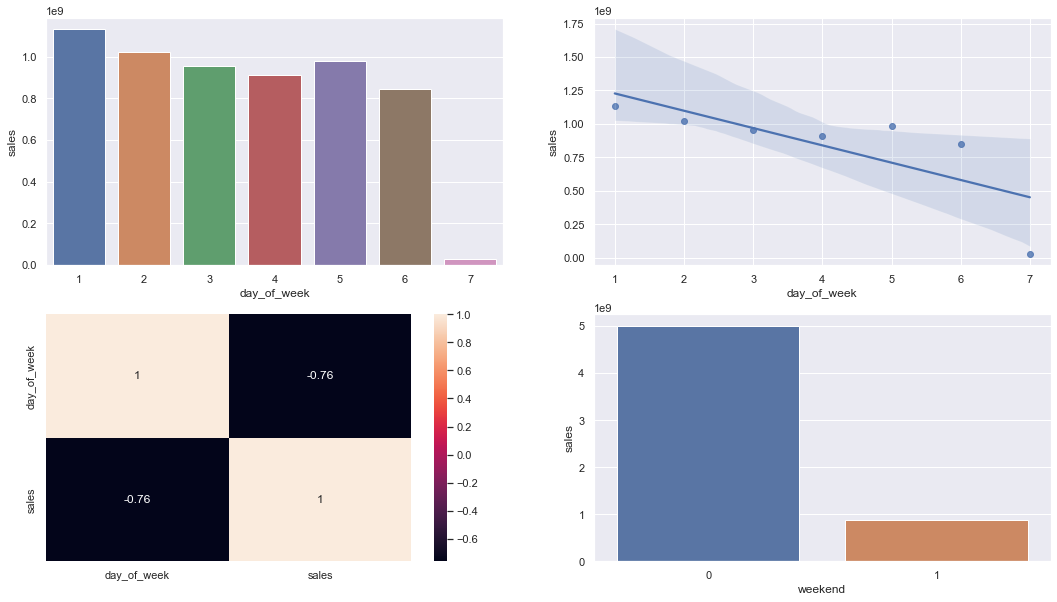

In [42]:
h11_aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot( x='day_of_week', y='sales', data=h11_aux1)

plt.subplot(2,2,2)
sns.regplot( x='day_of_week', y='sales', data=h11_aux1)

plt.subplot(2,2,3)
sns.heatmap(h11_aux1.corr(method='pearson'), annot=True)

# 1 = fim de semana
# 0 = semana
h11_aux1['weekend'] = h11_aux1['day_of_week'].apply(lambda x: 1 if x >= 6 else 0)
h11_aux2 = h11_aux1[['weekend','sales']].groupby('weekend').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot( x='weekend', y='sales', data=h11_aux2)

### **H12.** Lojas deveriam vender menos durante os feriados escolares.

**VERDADEIRA.** Lojas vendem menos durante os feriasdos escolares, exceto os meses de julho e agosto.

<AxesSubplot:xlabel='month', ylabel='sales'>

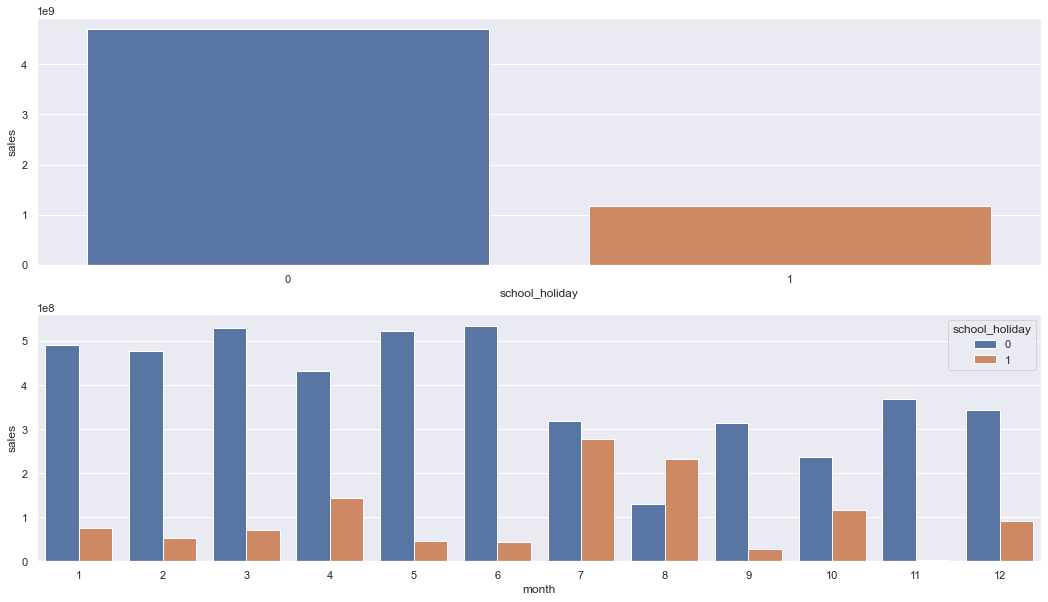

In [43]:
h12_aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot( x='school_holiday', y='sales', data=h12_aux1)

h12_aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot( x='month', y='sales', hue='school_holiday', data=h12_aux2)

## 4.3. Análise multivariada

### 4.3.1 Numerial Atributes

<AxesSubplot:>

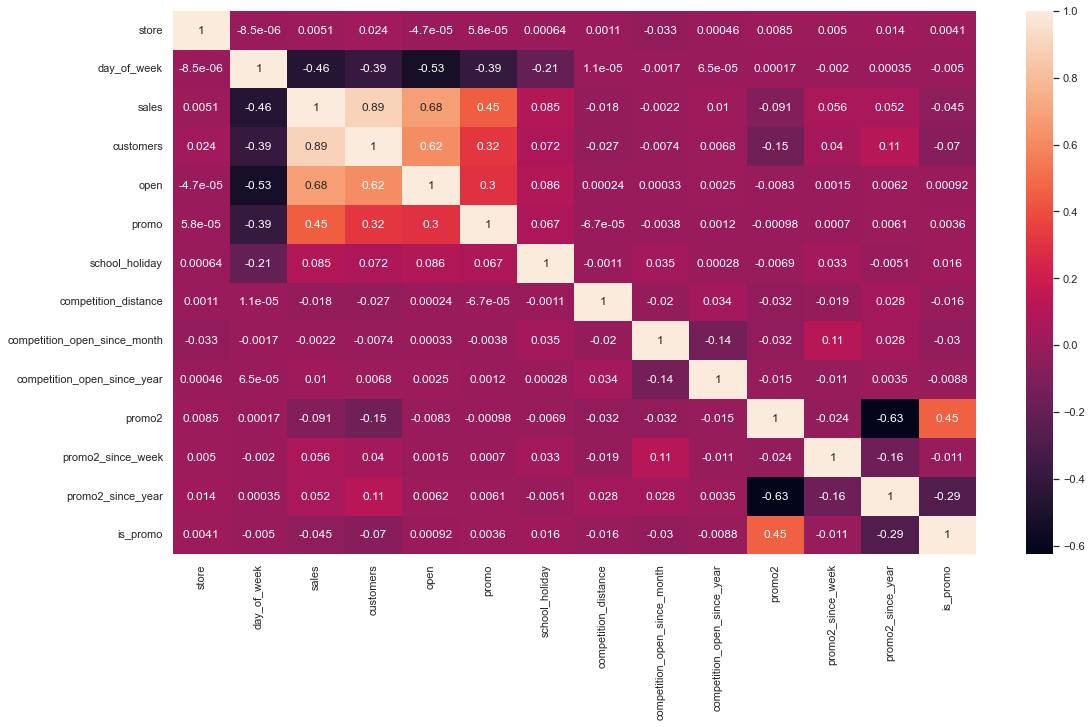

In [44]:
    correlation_num = num_attributes.corr( method= 'pearson')

    sns.heatmap(correlation_num, annot=True)

### 4.3.2 Categorical Atributes

<AxesSubplot:>

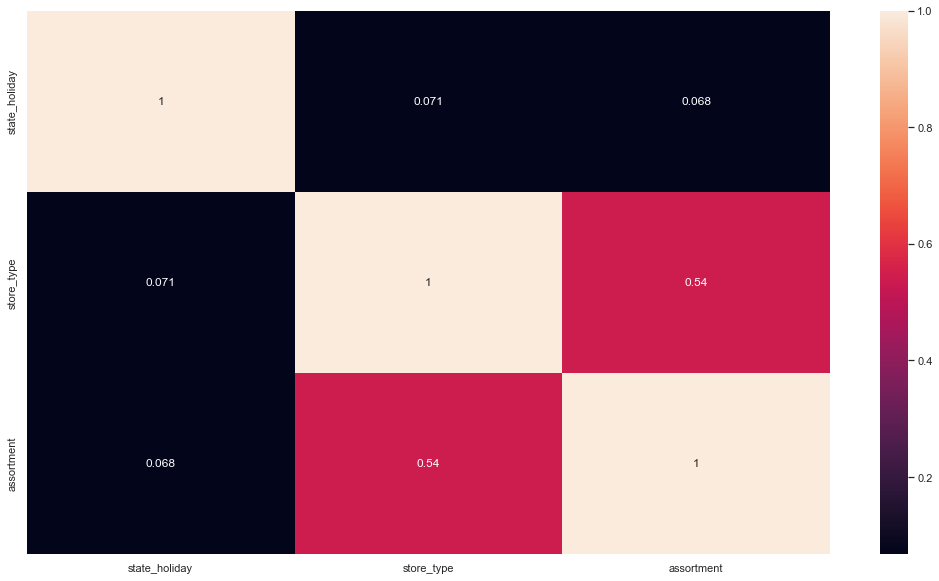

In [45]:
cat_atr = df4.select_dtypes( include= 'object')

a1 = cramer_v(cat_atr['state_holiday'],cat_atr['state_holiday'])
a2 = cramer_v(cat_atr['state_holiday'],cat_atr['store_type'])
a3 = cramer_v(cat_atr['state_holiday'],cat_atr['assortment'])

a4 = cramer_v(cat_atr['store_type'],cat_atr['state_holiday'])
a5 = cramer_v(cat_atr['store_type'],cat_atr['store_type'])
a6 = cramer_v(cat_atr['store_type'],cat_atr['assortment'])

a7 = cramer_v(cat_atr['assortment'],cat_atr['state_holiday'])
a8 = cramer_v(cat_atr['assortment'],cat_atr['store_type'])
a9 = cramer_v(cat_atr['assortment'],cat_atr['assortment'])

d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]   })

d = d.set_index( d.columns )

sns.heatmap(d, annot=True)

# 5.0 Preparação dos dados

In [22]:
df5 = df4.copy()

## 5.1. Normalização

Não há nenhuma variável próxima a uma normal, não é aconselhado aplicar essa técnica.

## 5.2. Rescaling

In [23]:
resc1 = df5.select_dtypes( include = ['int64', 'float64'])

In [26]:
# Variáveis não cíclicas
rs = RobustScaler()
# Variáveis cíclicas
mms = MinMaxScaler()

# competiton distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)
# Salvar as alterações dos dados para quando for colocar o modelo em produção
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pk1', 'wb' ))  

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values)
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pk1', 'wb' ))

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values)
pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pk1', 'wb' ))

# year
df5['year'] = mms.fit_transform( df5[['year']].values)
pickle.dump( mms, open( 'parameter/year_scaler.pk1', 'wb' ))

## 5.3. Transformação

### 5.3.1 Encoding

In [27]:
# state_holiday - estado - one hot encoding
df5 = pd.get_dummies( df5, prefix = ['state_holiday'], columns = ['state_holiday'] )

# story_type - label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pk1', 'wb' ))

# assortment - Encoding Ordinal
assortment_dict = { 'basic' : 1,
                    'extra' : 2,
                    'extended' : 3}

df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [28]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3 Nature Transformation

In [29]:
# Variáveis Cíclicas
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2 * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2 * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2 * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2 * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2 * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2 * np.pi/52 ) ) )

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2 * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2 * np.pi/7 ) ) )

# 6.0 Seleção de Variáveis

In [30]:
df6 = df5.copy()

## 6.1. Separação em Treino e Teste

In [31]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [ ]:
# Como estamos trabalhando com a temporariedado, não tem como separar aleatoriamente, então.
# Queremos prever as 6 semanas no futuro, para tal, pegaremos as 6 semanas mais recentes e colocaremos como teste.
# E todo o restante vai servir de treino.

# Onde estão as datas - 6 semanas de 7 dias
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days = 6*7 ) # Qual é o ponto de Separação Treino Teste

In [32]:
# Train Data Set
X_train = df6[df6['date'] < '2015-06-19']
# Variável resposta
Y_train = X_train['sales']

print('Training Mim Date: {}'.format(X_train['date'].min() ) )
print('Training Max Date: {}'.format(X_train['date'].max() ) )

# Test Data set
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

print('\nTest Mim Date: {}'.format(X_test['date'].min() ) )
print('Test Max Date: {}'.format(X_test['date'].max() ) )

Training Mim Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Mim Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Seleção com BORUTA

In [56]:
#Aqui o BORUTA TORA A MINHA MEMÓRIA. tIVE QUE USAR O GOOGLE COLAB.
#RESOLVIDO QUANDO FORMATEI O PC.

# train and test
X_train_n = X_train.drop(['date','sales'], axis =1).values
Y_train_n = Y_train.values.ravel()

#Define RandomForestRegressor
rf = RandomForestRegressor()

# Define Boruta
boruta = BorutaPy( rf, n_estimators = 'auto', verbose=2, random_state=42).fit( X_train_n, Y_train_n)

In [57]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [33]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 Algorítimos de ML

In [34]:
# Variáveis só para o modelo
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Todas as variáveis + Data + Sales para o cross_validation
X_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [60]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

# predicion
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns = {'sales':'prediction'} )
aux1 = pd.merge(aux1, aux2, how = 'left', on='store')
# estimativa do valor real - modelo
yhat_baseline = aux1['prediction']

# performace
base_line_result =  ml_error('Average Model', np.expm1( Y_test ), np.expm1( yhat_baseline ) )
base_line_result

## 7.2. Linear Regression Model

In [61]:
# model
lr = LinearRegression().fit( x_train, Y_train )

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error( 'Linea Regression', np.expm1( Y_test ), np.expm1( yhat_lr ) )
lr_result

### 7.2.1. Linear Regression Model Cross-Validation

In [62]:
lr_resoult_cv = cross_validation(  model_name = 'Linear Regression',
                                    X_training = X_training,
                                    kfold = 5,
                                    model = lr,
                                    verbose = False)
lr_resoult_cv

## 7.3. Linear Regression Regularized Model - Lasso

In [63]:
# model
lrr = Lasso( alpha = 0.01 ).fit( x_train, Y_train )

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error( 'Linea Regression Lasso', np.expm1( Y_test ), np.expm1( yhat_lrr ) )
lrr_result

### 7.3.1. Lasso Cross-Validation

In [64]:
lrr_resoult_cv = cross_validation(  model_name = 'Lasso',
                                    X_training = X_training,
                                    kfold = 5,
                                    model = lrr,
                                    verbose = False)
lrr_resoult_cv

## 7.4 Random Forest Regressor

In [65]:
# model
rf = RandomForestRegressor( n_estimators=100, random_state=42 ).fit( x_train, Y_train )

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( Y_test ), np.expm1( yhat_rf ) )
rf_result

### 7.4.1. Random Forest Regressor Cross-Validation

In [66]:
rf_resoult_cv = cross_validation(  model_name = 'Radom Forest Regressor',
                                    X_training = X_training,
                                    kfold = 5,
                                    model = rf,
                                    verbose = True)
rf_resoult_cv

## 7.5 XGBooster Regressor

In [67]:
# model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators=100,
                             eta = 0.01,
                             max_depth = 10,
                             subsample = 0.7,
                             colsample_bytree = 0.9 ).fit( x_train, Y_train )

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error( 'XGBRegressor', np.expm1( Y_test ), np.expm1( yhat_xgb ) )
xgb_result

### 7.5.1. XGBooster Cross-Validation

In [68]:
model_xgb_resoult_cv = cross_validation(model_name = 'XGBooster',
                                        X_training = X_training,
                                        kfold = 5,
                                        model = model_xgb,
                                        verbose = True)
model_xgb_resoult_cv

## 7.6 Compare Models Performace

### 7.6.1 Single Performance

In [69]:
# Rodando todos os modelos essa é a conta
modeling_resoult_2 = pd.concat([base_line_result,lr_result,lrr_result,rf_result,xgb_result])
modeling_resoult_2.sort_values('RMSE')

In [ ]:
# Cópia dos resultados para não precisar rodar todos os modeloa novamente
modeling_resoult = pd.DataFrame({
       'Model Name': ['Linea Regression Lasso', 'Average Model', 'Linea Regression', 'Random Forest Regressor', 'XGBRegressor'],
       'MAE': [679.598831, 1354.800353, 1863.628669, 1889.982643, 6683.448611],
       'MAPE': [0.099913, 0.455051, 0.292165, 0.288951, 0.949507],
       'RMSE': [1011.119437, 1835.135542, 2673.142689, 2745.968967, 7330.245861]})
modeling_resoult

### 7.6.2 Real Performance Cross-Validation

In [71]:
modeling_resoult_2 = pd.concat([lr_resoult_cv,lrr_resoult_cv,rf_resoult_cv,model_xgb_resoult_cv])
modeling_resoult_2

In [ ]:
modeling_resoult_cv = pd.DataFrame({
       'Model Name': ['Linea Regression', 'Lasso', 'Random Forest Regressor', 'XGBRegressor'],
       'MAE': ['2083.17 +/- 294.98', '2117.66 +/- 340.94', '836.61 +/- 217.1', '7049.2 +/- 588.65'],
       'MAPE': ['0.3 +/- 0.02', '0.29 +/- 0.01', '0.12 +/- 0.02', '0.95 +/- 0.0'],
       'RMSE': ['2958.87 +/- 466.72', '3061.89 +/- 503.23', '1254.3 +/- 316.17', '7715.2 +/- 689.51']})
modeling_resoult_cv

# 8.0 Hyperparameter Fine Tunning

## 8.1 Random Search

In [73]:
param = {'n_estimators' : [1500, 1700, 3000, 3500],
         'eta' : [0.01, 0.03],
         'max_depth' : [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree' : [0.3, 0.7, 0.9],
         'min_child_weight' : [3, 8, 15]}

MAX_EVAL = 10

In [74]:
final_result = pd.DataFrame()
for i in range (MAX_EVAL):
    # Escolher os parâmetros aleatórios
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print(hp)
    
    
    # model
    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                                 n_estimators=hp['n_estimators'],
                                 eta = hp['eta'],
                                 max_depth = hp['max_depth'],
                                 subsample = hp['subsample'],
                                 colsample_bytree = hp['colsample_bytree'],
                                 min_child_weight = hp['min_child_weight'])
    # performance
    
    result = cross_validation (model_name = 'XGBRegressor',
                               X_training = X_training,
                               kfold = 5,
                               model = model_xgb,
                               verbose = True )
    final_result = pd.concat([final_result, result])
final_result

## 8.2 Final Model

In [35]:
param_tunned = {'n_estimators' : 3000,
                'eta' : 0.03,
                'max_depth' : 5,
                'subsample': 0.7,
                'colsample_bytree' : 0.7,
                'min_child_weight' : 3}

In [36]:
# model
model_xgb_tunned = xgb.XGBRegressor(objective = 'reg:squarederror',
                                    n_estimators=param_tunned['n_estimators'],
                                    eta = param_tunned['eta'],
                                    max_depth = param_tunned['max_depth'],
                                    subsample = param_tunned['subsample'],
                                    colsample_bytree = param_tunned['colsample_bytree'],
                                    min_child_weight = param_tunned['min_child_weight']).fit(x_train, Y_train)
# prediction
yhat_xgb_tunned = model_xgb_tunned.predict( x_test )

# performance
xgb_result_tunned =  ml_error ( 'XGBRegressor', np.expm1( Y_test ), np.expm1( yhat_xgb_tunned ) )
xgb_result_tunned

,Model Name,MAE,MAPE,RMSE
0,XGBRegressor,767.8670,0.1153,1104.9996


# 9.0. Tradução e Interpretação do Erro

In [37]:
df9 = X_test[cols_selected_boruta_full].copy()

# Rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tunned )

## 9.1. Business Performance

In [38]:
# Somar as previsões/predictions - Lembra do problema de megócio, vê a previsão de cada loja...
df9_1 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE MAPE
df9_MAE = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'])).reset_index().rename( columns = {0:'MAE'})
df9_MAPE = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'])).reset_index().rename( columns = {0:'MAPE'})

# Merge
df9_aux1 = pd.merge(df9_MAE, df9_MAPE, how = 'inner', on = 'store')
df9_2 = pd.merge(df9_aux1, df9_1, how='inner', on='store')

# Cenários Futuros
df9_2['pior_cenario'] = df9_2['predictions'] - df9_2['MAE']
df9_2['melhor_cenario'] = df9_2['predictions'] + df9_2['MAE']
df9_2 = df9_2[['store', 'predictions', 'pior_cenario', 'melhor_cenario', 'MAE', 'MAPE']]

In [39]:
df9_2.head()

,store,predictions,pior_cenario,melhor_cenario,MAE,MAPE
0,1,167757.3125,167458.0548,168056.5702,299.2577,0.0686
1,2,182610.2656,182185.0089,183035.5224,425.2568,0.0852
2,3,268215.2188,267553.9617,268876.4758,661.2570,0.0915
3,4,343345.2812,342481.1498,344209.4127,864.1315,0.0823
4,5,171651.5469,171291.7850,172011.3088,359.7619,0.0809


In [40]:
df9_2.sort_values('MAPE', ascending= False). head()

,store,predictions,pior_cenario,melhor_cenario,MAE,MAPE
291,292,107615.7109,104215.9421,111015.4798,3399.7688,0.6024
908,909,218553.0625,210585.8192,226520.3058,7967.2433,0.5202
169,170,210332.7812,208754.9224,211910.6401,1577.8589,0.3889
901,902,202310.5469,200840.2079,203780.8859,1470.3390,0.3664
875,876,196113.0469,192048.9996,200177.0942,4064.0473,0.3288


<AxesSubplot:xlabel='store', ylabel='MAPE'>

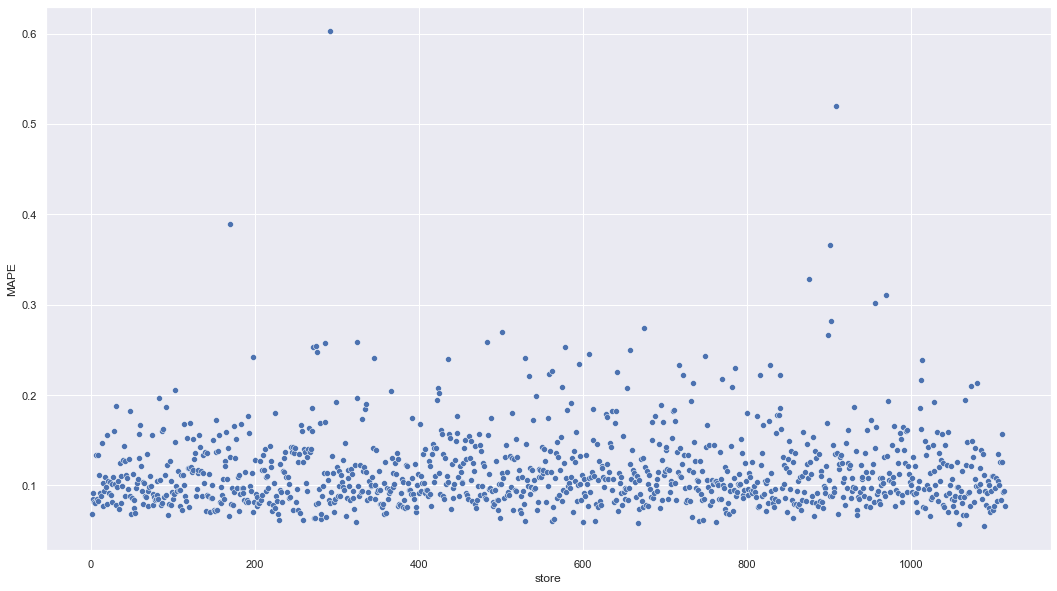

In [41]:
sns.scatterplot (x='store', y='MAPE', data=df9_2)

## 9.2. Total Performance

In [42]:
df9_3 = df9_2[['predictions', 'pior_cenario', 'melhor_cenario']].apply( lambda x: np.sum( x ), axis=0).reset_index().rename( columns = {'index':'cenarios', 0:'values'})
df9_3['values'] = df9_3['values'].map('R${:,.2f}'.format)
df9_3

,cenarios,values
0,predictions,"R$285,982,336.00"
1,pior_cenario,"R$285,122,909.38"
2,melhor_cenario,"R$286,841,799.87"


## 9.3. Machine Learning Performance

In [43]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

d:\Git_Hub\venv310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='predictions', ylabel='error'>

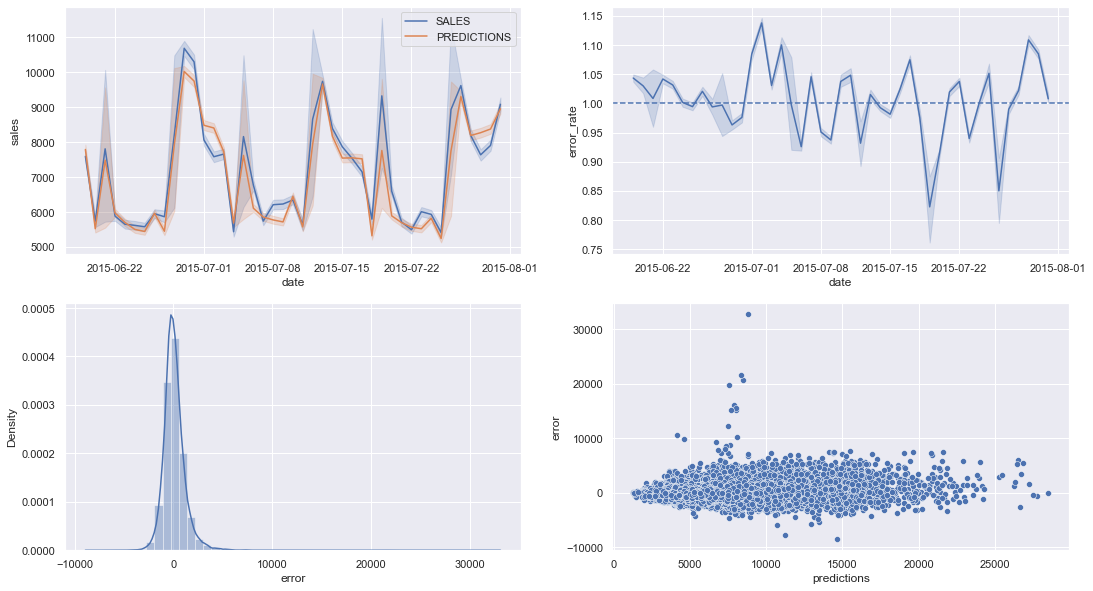

In [44]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline( 1, linestyle ='--')

plt.subplot(2,2,3)
sns.distplot( df9['error'] )

plt.subplot(2,2,4)
sns.scatterplot( x='predictions', y='error', data=df9 )

# 10.0. Deploy Modelo

In [86]:
#pickle.dump( model_xgb_tunned, open( 'model/model_rossmann.pk1', 'wb' ) )

## 10.1. Rossiman Class

In [11]:
class Rossmann ( object ):
    def __init__ (self):
        self.home_path = 'D:/Git_Hub/Cursos Estudo/@2205.1 - Data Science em Produção/' # Usado na maquina local
        #self.home_path = '' # Usado em produção
        self.competition_distance_scaler    = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pk1', 'rb' ) )
        self.competition_time_month_scaler  = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pk1', 'rb' ) )
        self.promo_time_week_scaler         = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pk1', 'rb' ) )
        self.year_scaler                    = pickle.load( open( self.home_path + 'parameter/year_scaler.pk1', 'rb' ) )
        self.store_type_scaler              = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pk1', 'rb' ))
    
    def data_clenning (self, df1):
        
        ## 1.1. Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
                    'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
                    'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x : inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old) )

        #rename
        df1.columns = cols_new


        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x : 2000000.0 if math.isnan( x ) else x)

        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x : x['date'].month
                                                        if math.isnan( x['competition_open_since_month'] )
                                                        else x['competition_open_since_month'],
                                                        axis = 1)

        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x : x['date'].year
                                                        if math.isnan( x['competition_open_since_year'] )
                                                        else x['competition_open_since_year'],
                                                        axis = 1)

        # promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x : x['date'].week
                                                        if math.isnan( x['promo2_since_week'] )
                                                        else x['promo2_since_week'],
                                                        axis = 1)

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x : x['date'].year
                                                        if math.isnan( x['promo2_since_year'] )
                                                        else x['promo2_since_year'],
                                                        axis = 1)

        # promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True ) # preenchimento do NA com 0 para facilitar a compraração

        df1['month_map'] = df1['date'].dt.month.map( month_map ) # Extração do mês da 'data' 

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else
                                                                                1 if x['month_map'] in x['promo_interval'].split(',') else 0,
                                                                                axis = 1)

        ## 1.6. Change types
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

        df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )
        
        return df1

    def feature_engineering (self, df2):
        
        ## 2.4. Feature Engineering
        # year
        df2['year'] = df2['date'].dt.year
        # month
        df2['month'] = df2['date'].dt.month
        # day
        df2['day'] = df2['date'].dt.day
        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week
        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')
        
        # competition since - quanto tempo da data da compra desde quando a competição começou
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype('int64')
        
        # promo since
        
        df2['promo_since'] = df2['promo2_since_year'].astype('str') + '-' + df2['promo2_since_week'].astype('str')
        
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x +'-1', '%Y-%W-%w') - datetime.timedelta(days=7) )
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) /7).apply( lambda x: x.days).astype('int64')
        
        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a'
                                                    else'extra' if x == 'b'
                                                    else 'extended')
        
        # state hollyday
        df2['state_holiday'] = df2['state_holiday'].apply(  lambda x: 'public_holiday' if x == 'a'
                                                            else 'easter_holiday' if x == 'b'
                                                            else 'christmas' if x == 'c'
                                                            else 'regular_day')
        # 3.0 FILTRAGEM DAS VARIÁVEIS
        
        ## 3.1. Filtragem das Linhas
        df2 = df2[(df2['open'] != 0)]
        
        ## 3.2. Seleção das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    def data_preparation (self, df5, ft):

        ## 5.2. Rescaling
        resc1 = df5.select_dtypes( include = ['int64', 'float64'])
        
        # competiton distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values)
        
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values)
        
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values)
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values)
        
        ## 5.3. Transformação
        ### 5.3.1 Encoding
        # state_holiday - estado - one hot encoding
        df5 = pd.get_dummies( df5, prefix = ['state_holiday'], columns = ['state_holiday'] )

        # story_type - label encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Encoding Ordinal
        assortment_dict = { 'basic' : 1,
                            'extra' : 2,
                            'extended' : 3}

        df5['assortment'] = df5['assortment'].map(assortment_dict)
        
        ### 5.3.3 Nature Transformation
        # Variáveis Cíclicas
        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2 * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2 * np.pi/12 ) ) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2 * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2 * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2 * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2 * np.pi/52 ) ) )

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2 * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2 * np.pi/7 ) ) )
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance',
                                'competition_open_since_month', 'competition_open_since_year', 'promo2',
                                'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
                                'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
                                'week_of_year_sin', 'week_of_year_cos']
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join prediction into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient = 'records', date_format = 'iso' )
    
    

## 10.2. API Handler

In [45]:
# load model
model = pickle.load( open( 'D:/Git_Hub/Cursos Estudo/@2205.1 - Data Science em Produção/model/model_rossmann.pk1', 'rb') )

# inicialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods = ['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json:
        
        if isinstance(test_json, dict): # Unique Example
            test_raw = pd.DataFrame( test_json, index=[0])
        
        else: # Multiple Example
            test_raw = pd.DataFrame( test_json, columns = test_json[0].keys())
    
        # Instanciar a Rossmann Class AQUI QUE A MAGIA ACONTECE
        pipeline = Rossmann()
        
        # Data Cleanning
        df1 = pipeline.data_clenning(test_raw)
        # Feature Engeneering
        df2 = pipeline.feature_engineering(df1)
        # Data Preparation
        df3 = pipeline.data_preparation(df2)
        # Prediction
        df_responde = pipeline.get_prediction(model, test_raw, df3)

        return df_responde
    
    else:
        return Response({}, status=200, minetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0')

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.0.10:5000 (Press CTRL+C to quit)


## 10.3. API Test

In [46]:
df10 = pd.read_csv('data_set/test.csv')

In [47]:
# merge store
df_test = pd.merge( df10, df_store_raw, how = 'left', on = 'Store' )

df_test = df_test[df_test['Store'] <= 20]

# removed closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis =1)

In [48]:
# convet DataFrame to json
data = json.dumps( df_test.to_dict( orient= 'record') )

C:\Users\gbnob\AppData\Local\Temp\ipykernel_11668\4082490246.py:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  data = json.dumps( df_test.to_dict( orient= 'record') )


In [49]:
# API Call
url = 'http://127.0.0.1:5000/rossmann/predict' # Usado na maquina local
#url = 'https://regression-1-gng-rossmann.herokuapp.com/rossmann/predict' # Usado em produção
header = {'Content-Type': 'application/json'}
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /rossmann/predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000224A7A0B0D0>: Failed to establish a new connection: [WinError 10061] Nenhuma conexão pôde ser feita porque a máquina de destino as recusou ativamente'))

In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [ ]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

In [ ]:
d2.head()